In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(cowplot)
    library(scales)
    library(scico)
    library(ggnewscale)
    theme_set(theme_cowplot())
})
options(repr.plot.width=16,repr.plot.height=10, width=120)

# Scale Transforms

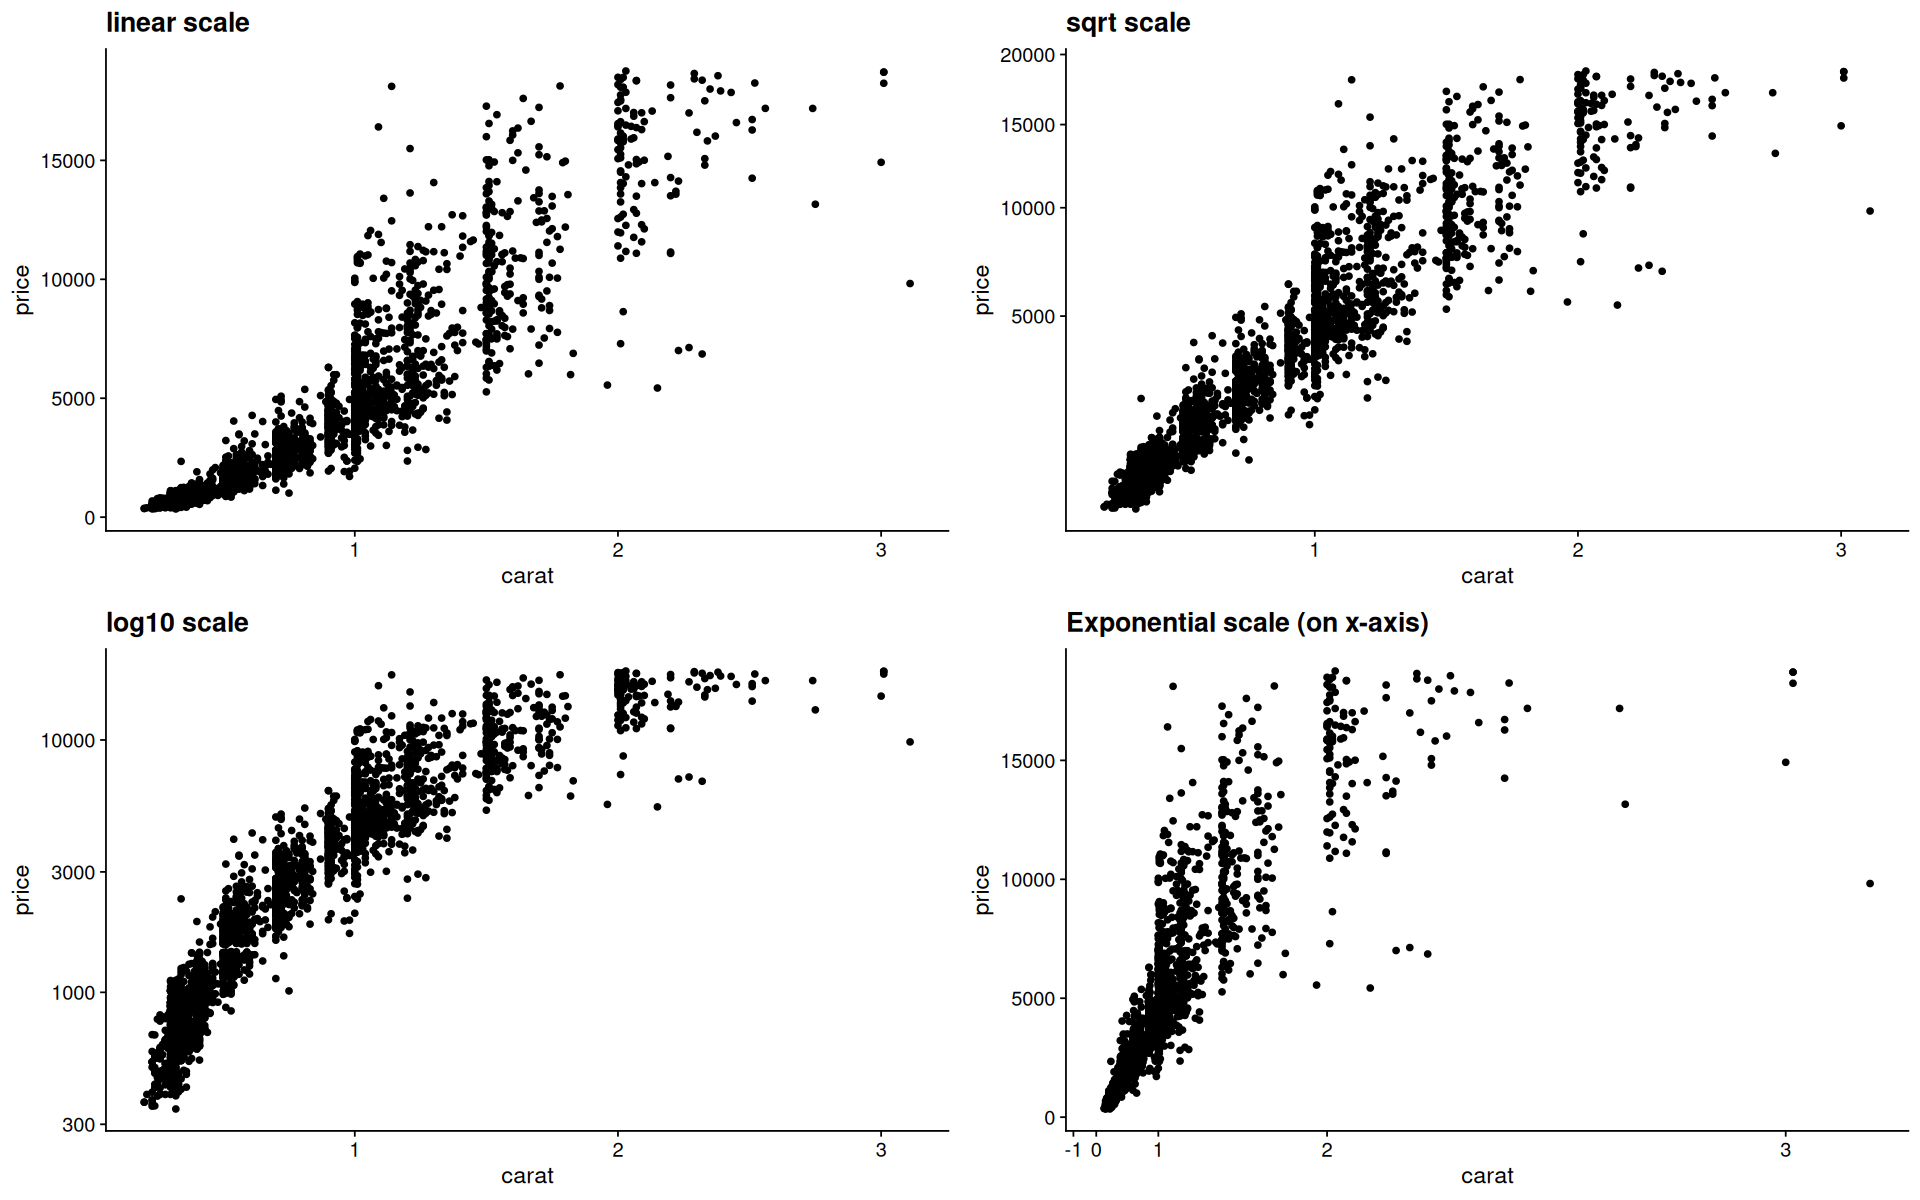

In [80]:
set.seed(42)
p1 <- 
sample_n(diamonds, 3e3) |>
ggplot(aes(x=carat, y=price)) + 
geom_point() + 
ggtitle('linear scale')

p2 <- p1 + scale_y_sqrt() + ggtitle('sqrt scale')
p3 <- p1 + scale_y_log10() + ggtitle('log10 scale')
p4 <- p1 + scale_x_continuous(trans=exp_trans()) + ggtitle('Exponential scale (on x-axis)') 

plot_grid(p1,p2,p3,p4)

# Log-scale extension for negative numbers

In [3]:
set.seed(42)

my_breaks <- c(-2**(0:9), 0, 2**(0:9))

d <- tibble(
    x=sample(c(-1,1),size=1e3,replace=T) * 2**(rnorm(1e3, mean=2,sd=2)),
    x_abs = abs(x),
    sign = factor(sign(x))
)
cat('overrall summary:')
summary(d$x)
cat('pos side summary:')
filter(d, sign==1) |> with(summary(x))
cat('neg side summary:')
filter(d, sign==-1) |> with(summary(x))

overrall summary:

             Min.           1st Qu.            Median              Mean           3rd Qu.              Max. 
-508.677872465045   -3.908494399281    0.049148252936   -1.110086588027    3.971163581176  154.067539902141 

pos side summary:

             Min.           1st Qu.            Median              Mean           3rd Qu.              Max. 
  0.0373311001264   1.5039575999604   3.9688275291219   9.0798124293071  10.3274449533110 154.0675399021411 

neg side summary:

             Min.           1st Qu.            Median              Mean           3rd Qu.              Max. 
-508.677872465045   -9.311123141912   -3.928010252557  -11.340826883987   -1.604767481836   -0.116012349882 

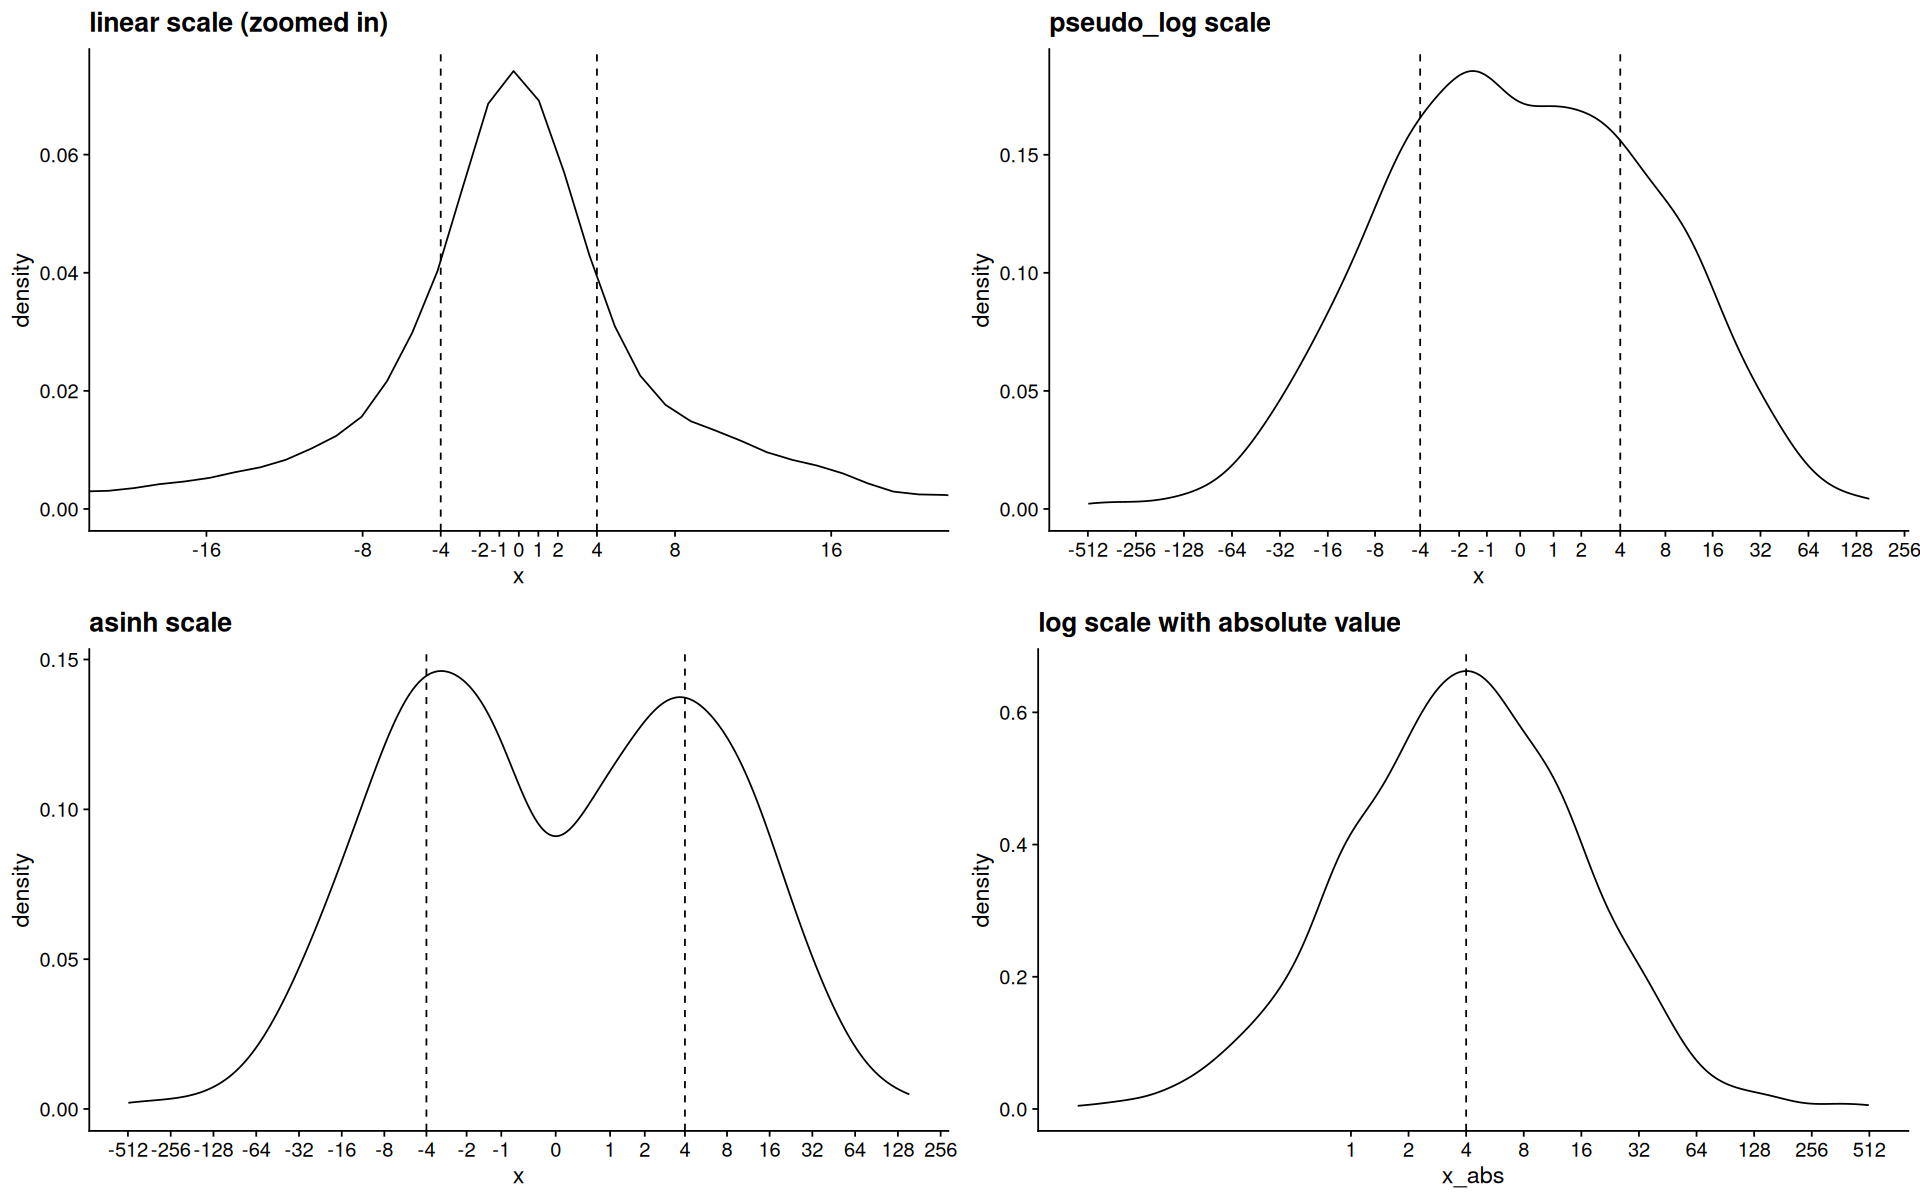

In [4]:
p <- ggplot(d, aes(x=x)) + 
geom_density() + 
geom_vline(xintercept=c(-4,4),linetype=2)

p1 <- p +
coord_cartesian(xlim=c(-20,20)) +
scale_x_continuous(breaks=my_breaks) +
ggtitle('linear scale (zoomed in)')

p2 <- p + scale_x_continuous(trans=pseudo_log_trans(), breaks=my_breaks) + ggtitle('pseudo_log scale')
p3 <- p + scale_x_continuous(trans=asinh_trans(),breaks=my_breaks) + ggtitle('asinh scale')

p4 <-
ggplot(d,aes(x=x_abs)) + 
geom_density() +
scale_x_log10(breaks=keep(my_breaks, ~.x>0)) +
geom_vline(xintercept=4,linetype=2) + ggtitle('log scale with absolute value')

plot_grid(p1,p2,p3,p4)

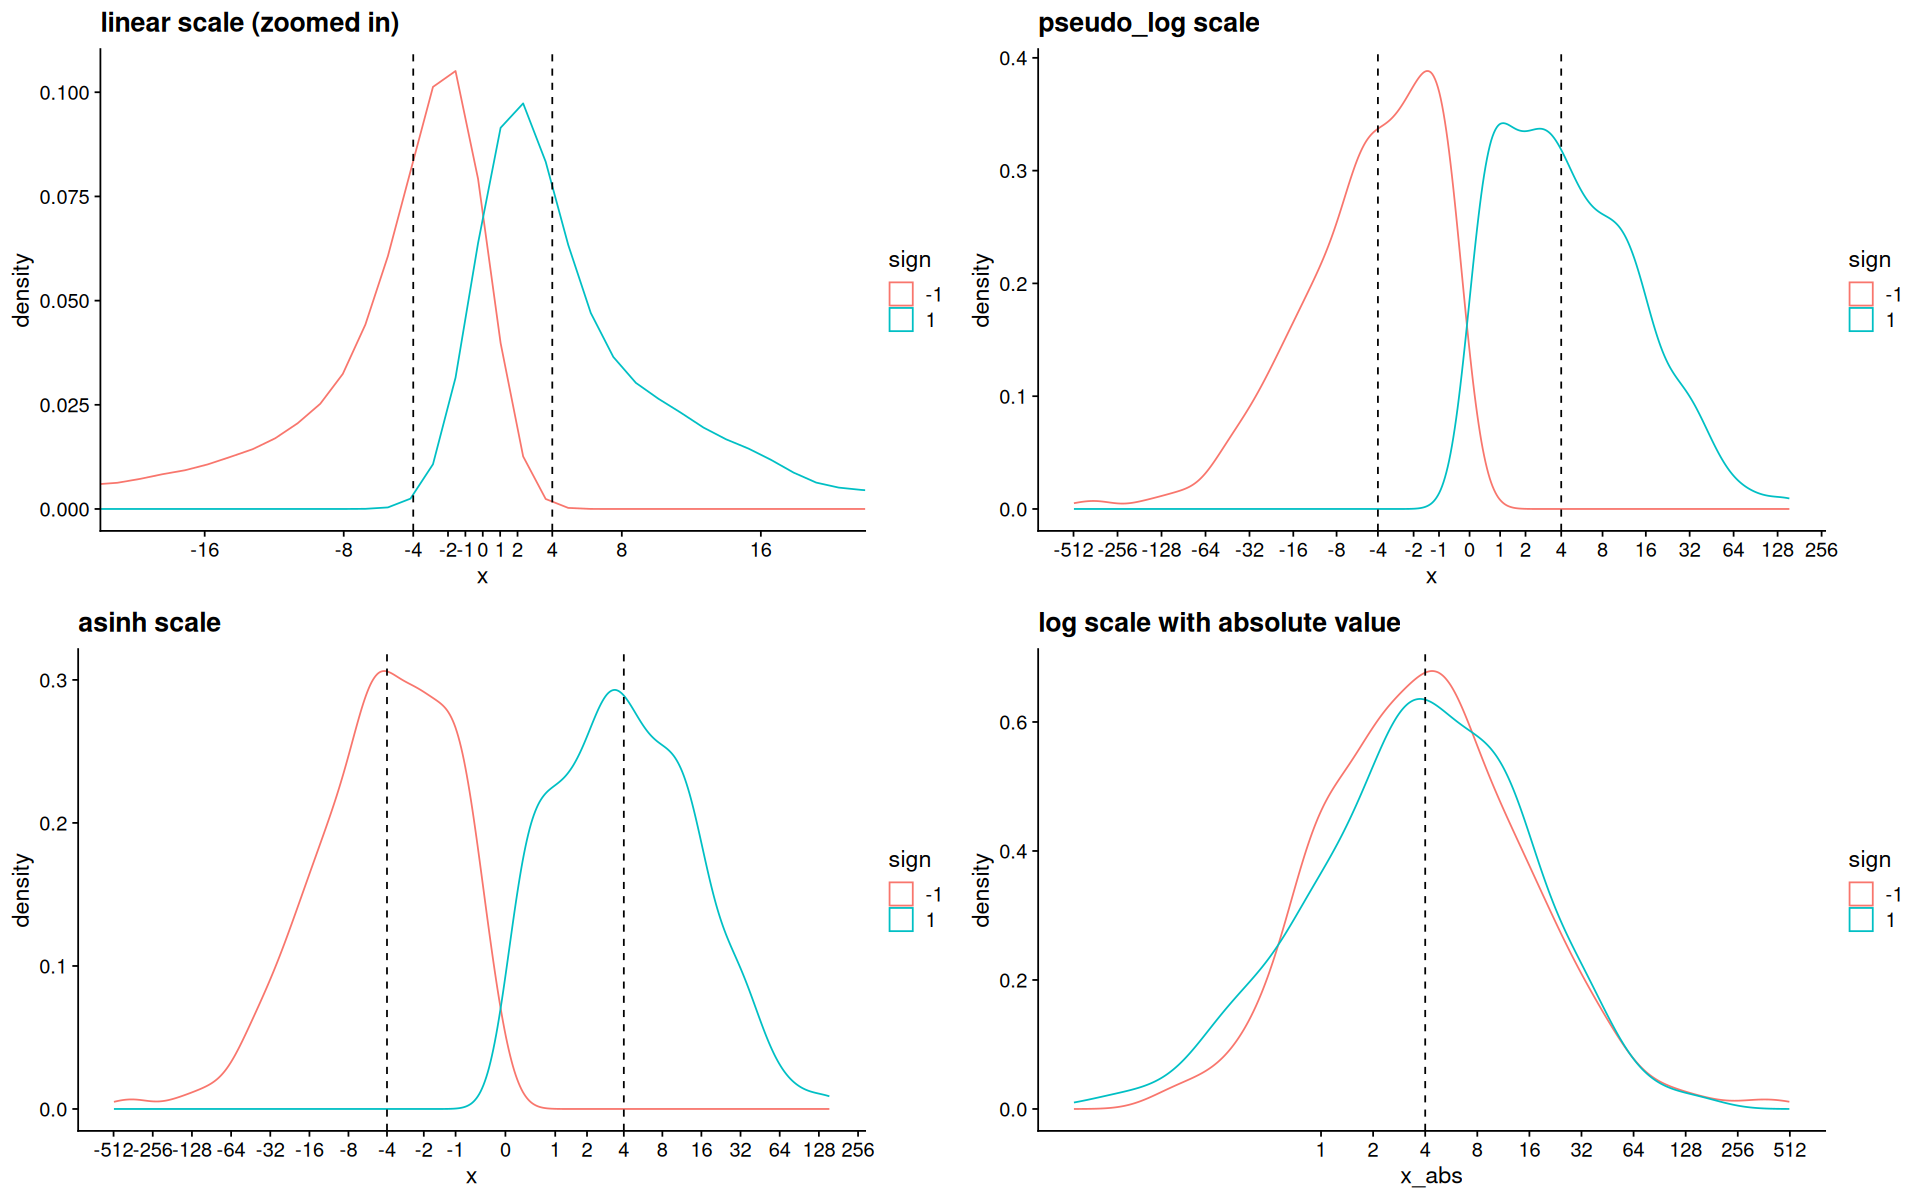

In [5]:
p <- ggplot(d, aes(x=x, color=sign)) + 
geom_density() + 
geom_vline(xintercept=c(-4,4),linetype=2)

p1 <- p +
coord_cartesian(xlim=c(-20,20)) +
scale_x_continuous(breaks=my_breaks) +
ggtitle('linear scale (zoomed in)')

p2 <- p + scale_x_continuous(trans=pseudo_log_trans(), breaks=my_breaks) + ggtitle('pseudo_log scale')
p3 <- p + scale_x_continuous(trans=asinh_trans(),breaks=my_breaks) + ggtitle('asinh scale')

p4 <-
ggplot(d,aes(x=x_abs, color=sign)) + 
geom_density() +
scale_x_log10(breaks=keep(my_breaks, ~.x>0)) +
geom_vline(xintercept=4,linetype=2) + ggtitle('log scale with absolute value')

plot_grid(p1,p2,p3,p4)

note that, `pseudo_log` is defined in terms of `asinh`:

In [6]:
pseudo_log_trans()$transform

function (x) 
asinh(x/(2 * sigma))/log(base)
<bytecode: 0x584ff4bfaff0>
<environment: 0x584ff60e0050>

# Transforms Comparison

Warning message in sqrt(x):
"NaNs produced"
Warning message in log(x):
"NaNs produced"


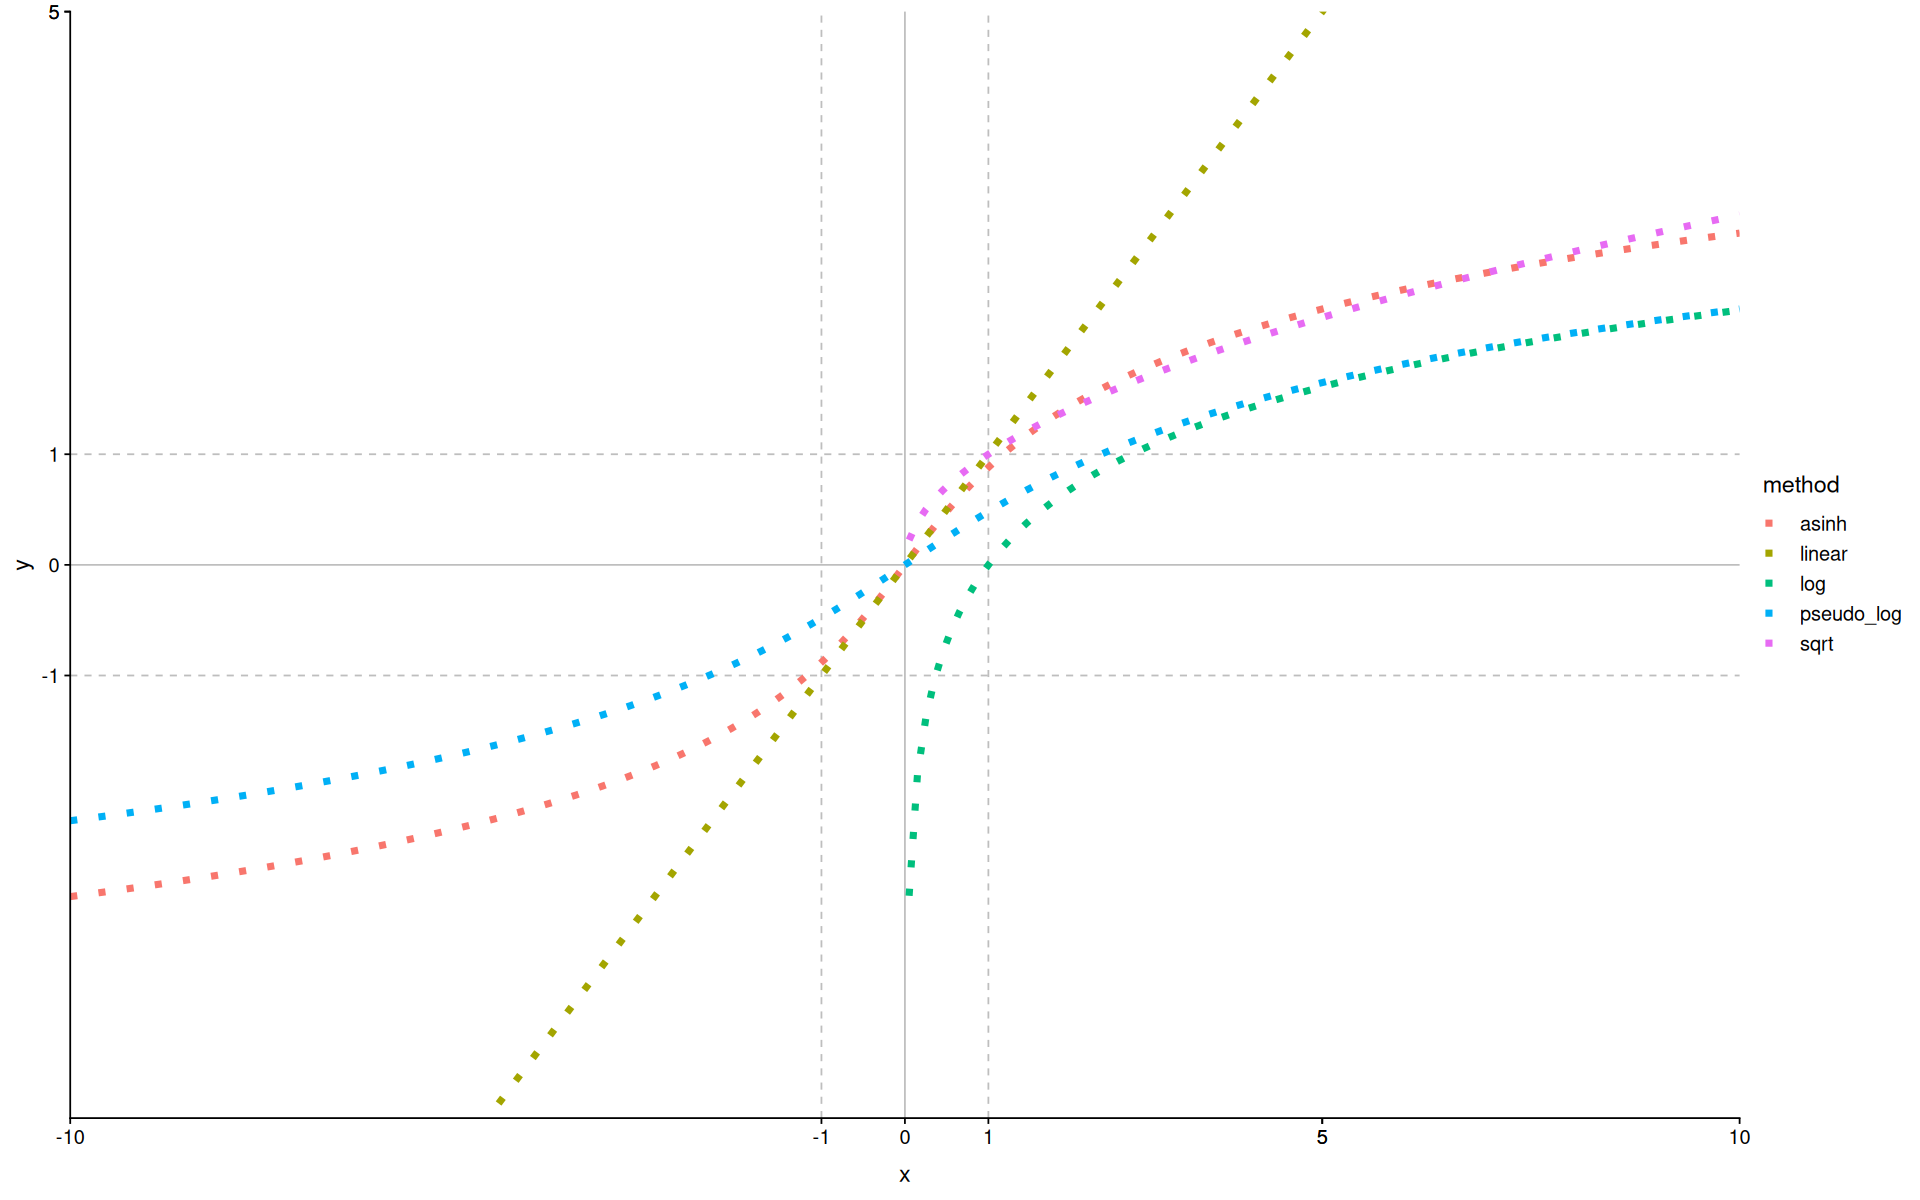

In [10]:
tibble(
    x=seq(-10, 10, length.out = 200),
    linear=x,
    sqrt=sqrt(x),
    log=log(x),
    asinh=asinh(x),
    pseudo_log=pseudo_log_trans()$transform(x)
) |>
pivot_longer(names_to = 'method', values_to = 'y', -x) |>
filter(!is.na(y)) |>
ggplot(aes(x=x, y=y, color=method)) +
scale_x_continuous(breaks=c(-10, 5, -1, 0, 1, 5, 10)) +
scale_y_continuous(breaks=c(-10, 5, -1, 0, 1, 5, 10)) +
geom_hline(yintercept=c(-1,0,1), linetype=c(2,1,2), color='gray') +
geom_vline(xintercept=c(-1,0,1), linetype=c(2,1,2), color='gray') +
geom_line(linewidth=2, linetype=3) +
coord_cartesian(expand=0, xlim=c(-10,10),ylim=c(-5,5))

# More transforms with Box-Cox

The [Box-Cox transform](https://scales.r-lib.org/reference/transform_boxcox.html) is a parameterized [power transform](https://en.wikipedia.org/wiki/Power_transform) that allows you to control the degree of the transformation, often used to transform data towards normality.

The code is actually using `modulus_trans`, which is a generalization of box-cox for negative numbers.

In [8]:
d <-
    tibble(
        x=seq(-10, 10, length.out = 200),
    ) |>
    reduce(seq(-2, 2, 0.25), function(df, i) {
        mutate(df, "p={i}" := modulus_trans(p=i)$transform(x))
    }, .init=_) |>
    pivot_longer(names_to = 'method_boxcox', values_to = 'y', -x) |> 
    mutate(method_boxcox=fct_reorder2(method_boxcox, x, y))

d2 <- tibble(
        x=seq(-10, 10, length.out = 200),
        linear=x,
        log=log(x),
        sqrt=sqrt(x),
        asinh=asinh(x),
        pseudo_log=pseudo_log_trans()$transform(x)
    ) |>
    pivot_longer(names_to = 'method_other', values_to = 'y', -x) |> 
    na.omit(y)

Warning message in log(x):
"NaNs produced"
Warning message in sqrt(x):
"NaNs produced"


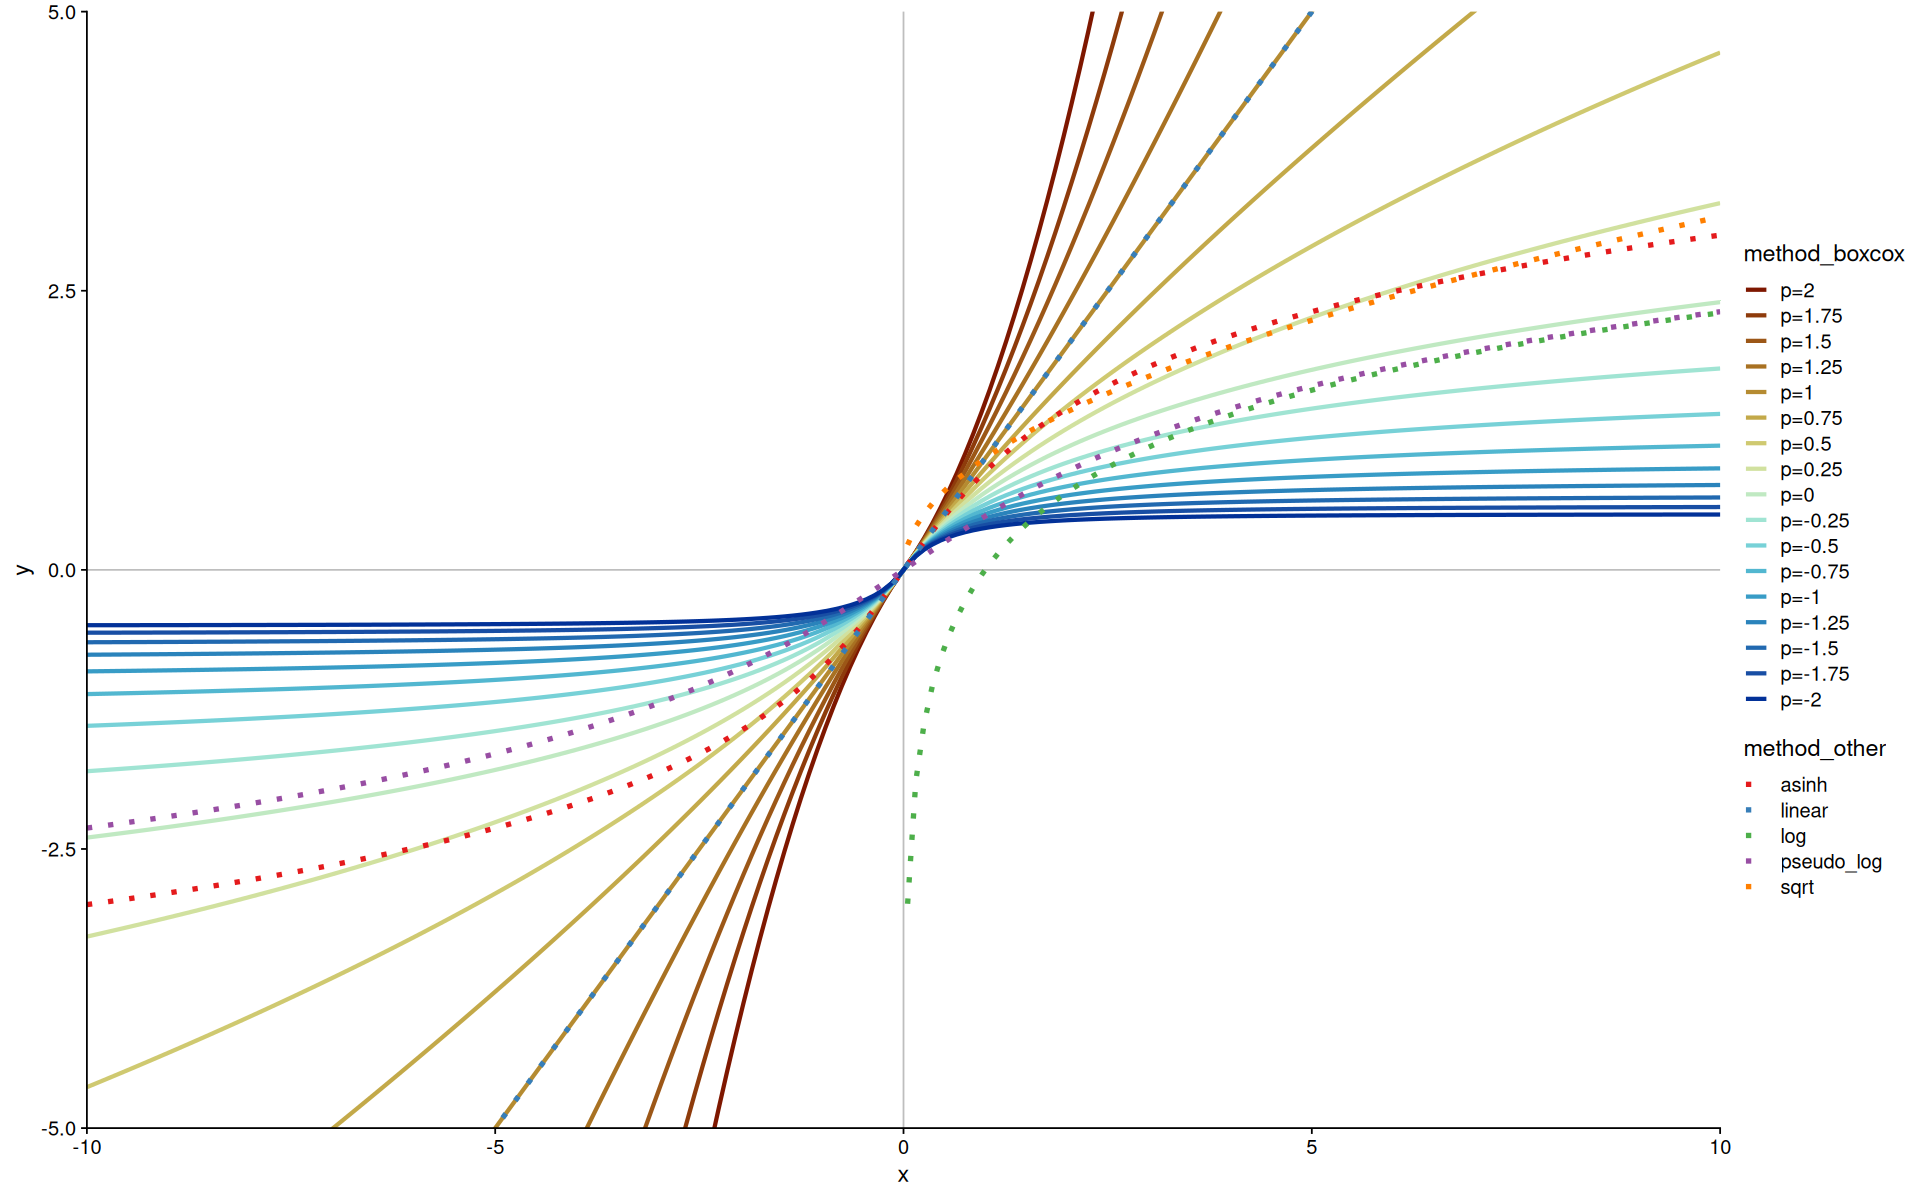

In [11]:
d |>
ggplot(aes(x=x, y=y, color=method_boxcox)) +
geom_hline(yintercept=0, color='gray') +
geom_vline(xintercept=0, color='gray') +
coord_cartesian(expand=0, xlim=c(-10,10),ylim=c(-5,5)) +
geom_line(size=1.2) +
scale_color_scico_d(palette='roma') +
new_scale_color() +
geom_line(size=1.5, inherit.aes = FALSE, data=d2,aes(x,y,color=method_other), linetype=3) +
scale_color_brewer(palette='Set1')